In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from hs2 import herdingspikes
from probe import NeuralProbe, NeuroPixel, BioCam
import numpy as np

%matplotlib inline

/disk/scratch/mhennig/venvs/theano/lib64/python3.4/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
Probe = BioCam()
H = herdingspikes(Probe)

In [3]:
path = '/data/MEA/LightStim/PVDREADD_P63_09_08_2016/'
path = '/disk/scratch/mhennig/PVDREADD_P63_09_08_2016/'
lfile = 'PVDREADD_P63_09_08_2016_stim1_basic_CTL_v28Format.hdf5'
# lfile = 'PVDREADD_P63_09_08_2016_stim2_SWN_CTL_v28Format.hdf5'
# path = '/data/MEA/LightStim/P29_16_07_14/HdfFilesSpkD45_dev/'
# path = '/disk/scratch/mhennig//P29_16_07_14/HdfFilesSpkD45_dev/'
# lfile = 'P29_16_05_14_retina01_right_stim2_smallarray_fullfield_v28_clustered_0.3_0.34_align_multi.hdf5'
# lfile = 'P29_16_05_14_retina01_right_stim1_smallarray_whitenoise100ms_v28_clustered_0.3_0.38_multi.hdf5'
H.Load_HDF5_legacy(path+lfile, chunk_size=1000000, compute_amplitudes=False)

Reading from /disk/scratch/mhennig/PVDREADD_P63_09_08_2016/PVDREADD_P63_09_08_2016_stim1_basic_CTL_v28Format.hdf5
Creating memmapped cache for shapes, reding in chunks, converting to integer...
Found 5 data points out of linear regime in chunk 1
Found 2 data points out of linear regime in chunk 2
Found 11 data points out of linear regime in chunk 3
Found 11 data points out of linear regime in chunk 4
Found 22 data points out of linear regime in chunk 5
Found 0 data points out of linear regime in chunk 6
Found 23 data points out of linear regime in chunk 7
Found 12 data points out of linear regime in chunk 8
Found 12 data points out of linear regime in chunk 9
Found 6 data points out of linear regime in chunk 10
Found 16 data points out of linear regime in chunk 11
Found 0 data points out of linear regime in chunk 12
Found 13 data points out of linear regime in chunk 13
Found 23 data points out of linear regime in chunk 14
Found 19 data points out of linear regime in chunk 15
Found 1496

We have 14964954 spikes, only showing 200000


(-2.8036996008781556,
 66.804934668722552,
 -2.8844458773918586,
 66.834894986469308)

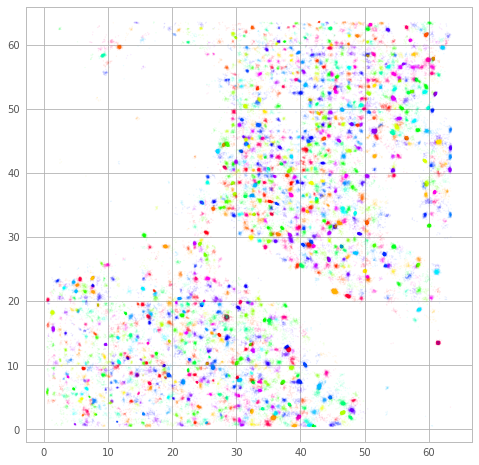

In [4]:
# overview
plt.figure(figsize=(8, 8))
H.PlotAll(invert=True, s=1, alpha=0.05)
plt.axis('equal')

# Spike sorting

In [18]:
%%time
# There are several methods available now

# This is the old mean shift:
# H.CombinedClustering(alpha=0.3,
#                     bandwidth = 0.3, bin_seeding=True, min_bin_freq=150,
#                     pca_ncomponents=2, pca_whiten=True,
#                     n_jobs=-1, recompute_pca=False)

# mean shift local
# from sklearn.cluster import DBSCAN
from clustering.mean_shift_ import MeanShift
H.CombinedClustering(bandwidth=0.3, bin_seeding=True, alpha=0.3, clustering_algorithm=MeanShift,
                    min_bin_freq=100, pca_ncomponents=2, pca_whiten=True,
                    n_jobs=-1)

# DBScan, better results
# from sklearn.cluster import DBSCAN
# H.CombinedClustering(eps=0.2, alpha=0.4, clustering_algorithm=HDBSCAN,
#                     min_samples=5, pca_ncomponents=2, pca_whiten=True,
#                     n_jobs=-1)

# HDBScan, best results
# import hdbscan
# # H.CombinedClustering(min_cluster_size=10, alpha=0.6, clustering_algorithm=HDBSCAN,
# #                     min_samples=5, pca_ncomponents=2, pca_whiten=True)

# H.CombinedClustering(min_cluster_size=10, alpha=0.2, clustering_algorithm=hdbscan.HDBSCAN,
#                     min_samples=10, pca_ncomponents=2, pca_whiten=True, core_dist_n_jobs=12, 
#                      algorithm='best', approx_min_span_tree=True)

Clustering...
total number of seeds: 27594
seeds/job: 2300
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:  3.1min remaining:  9.4min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:  3.3min remaining:   40.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:  3.4min finished


Number of estimated clusters: 1660
CPU times: user 9min 51s, sys: 2.39 s, total: 9min 53s
Wall time: 9min 52s


We have 14964954 spikes, only showing 200000


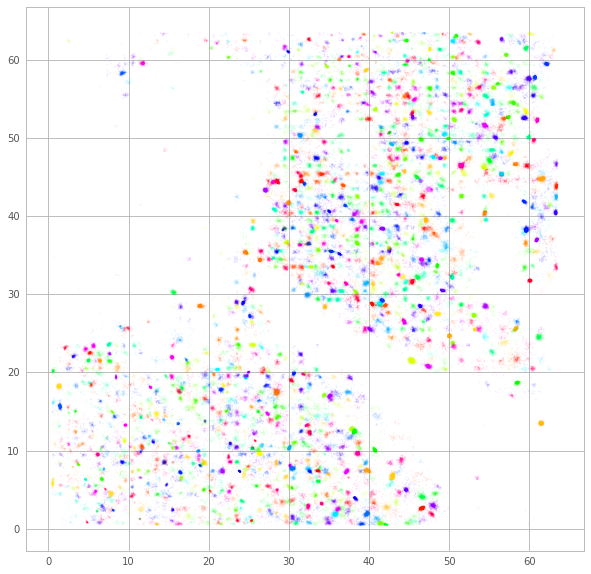

In [19]:
plt.figure(figsize=(10, 10))
H.PlotAll(invert=True, s=1, alpha=0.05)

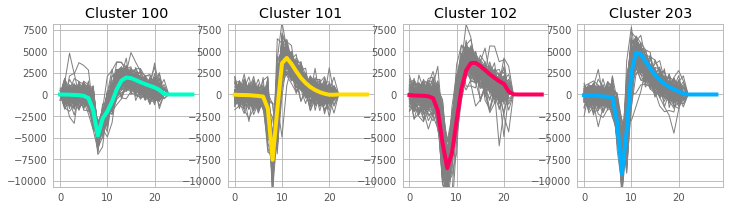

In [20]:
# Show a few units

units = (100, 101, 102, 203)
H.PlotShapes(units)

334


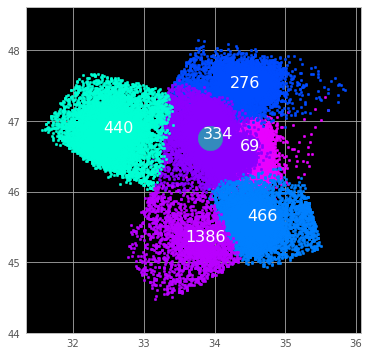

In [27]:
# sort by cluster size, select one, and plot in space
# unclustered spikes are shown in white

# which cluster should be shown
cluster_number = 200
radius = 1.5

plt.figure(figsize=(6,6))
ax = plt.axes(facecolor='k')
largest = np.argsort(H.clusters['Size']).values[::-1]
cl = largest[cluster_number]
print(cl)
cx, cy = H.clusters['ctr_x'][cl],H.clusters['ctr_y'][cl]
dists = np.sqrt((cx-H.clusters['ctr_x'])**2+(cy-H.clusters['ctr_y'])**2)
clInds = np.where(dists<radius)[0]
for cl_t in clInds:
    cx, cy = H.clusters['ctr_x'][cl_t],H.clusters['ctr_y'][cl_t]
    inds = np.where(H.spikes.cl==cl_t)[0]
    x,y = H.spikes.x[inds],H.spikes.y[inds]
    plt.scatter(x,y,c=plt.cm.hsv(H.clusters['Color'][cl_t]), s=6,alpha=1)
    plt.text(cx-0.1,cy,str(cl_t), fontsize=16, color='w')
plt.axis('equal');
# slice out the unclustered spikes
# is there a better way?
cx, cy = H.clusters['ctr_x'][cl],H.clusters['ctr_y'][cl]
inds = np.where(H.spikes.cl==-1)[0]
x,y = H.spikes.x[inds].values, H.spikes.y[inds].values
dists = np.sqrt((cx-x)**2+(cy-y)**2)
spInds = np.where(dists<radius)[0][:1000]
plt.scatter(x[spInds], y[spInds], c='w', s=6, alpha=0.4)

# plt.scatter(H.clusters.ctr_x[cl], H.clusters.ctr_y[cl],marker='o',s=600)
plt.scatter(H.centerz[cl][0], H.centerz[cl][1],marker='o',s=600)

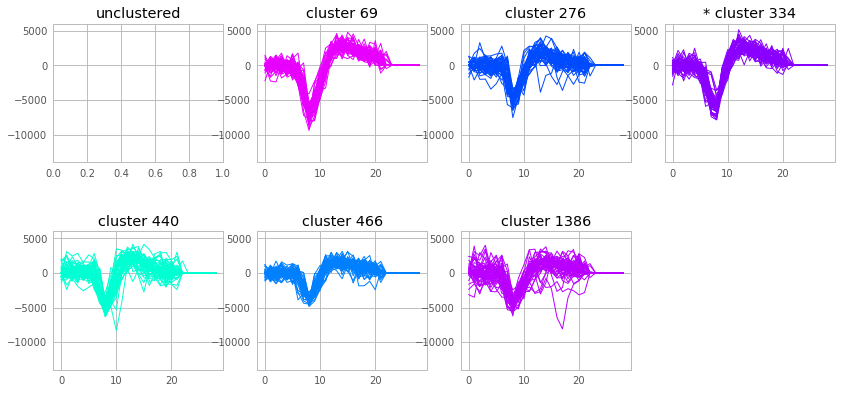

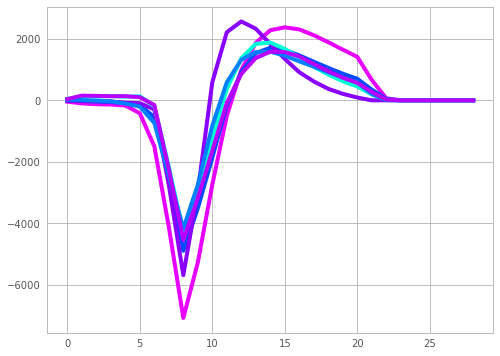

In [28]:
# waveforms for the spikes above
# * identifies the selected cluster above

plt.figure(figsize=(14,14))
cx, cy = H.clusters['ctr_x'][cl],H.clusters['ctr_y'][cl]
plt.subplot(4,4,1)
inds = np.where(H.spikes.cl==-1)[0]
x,y = H.spikes.x[inds].values, H.spikes.y[inds].values
dists = np.sqrt((cx-x)**2+(cy-y)**2)
spInds = np.where(dists<radius)[0][:20]
for i in inds[spInds]:
    plt.plot(H.spikes.Shape[i],'gray')
plt.ylim((-14000,6000))    
plt.title('unclustered')
dists = np.sqrt((cx-H.clusters['ctr_x'])**2+(cy-H.clusters['ctr_y'])**2)
clInds = np.where(dists<radius)[0]
for i,cl_t in enumerate(clInds[:15]):
    plt.subplot(4,4,i+2)
    spInds = np.where(H.spikes.cl==cl_t)[0]
    for i in spInds[:50]:
        plt.plot(H.spikes.Shape[i],color=plt.cm.hsv(H.clusters['Color'][cl_t]))#'k')
    plt.ylim((-14000,6000))    
    if cl_t==cl:
        plt.title('* cluster '+str(cl_t))
    else:
        plt.title('cluster '+str(cl_t))

plt.figure(figsize=(8,6))
inds = np.where(H.spikes.cl==-1)[0]
x,y = H.spikes.x[inds].values, H.spikes.y[inds].values
dists = np.sqrt((cx-x)**2+(cy-y)**2)
spInds = np.where(dists<radius)[0]
plt.plot(H.spikes.Shape[spInds].mean(),'gray',lw=4)
dists = np.sqrt((cx-H.clusters['ctr_x'])**2+(cy-H.clusters['ctr_y'])**2)
clInds = np.where(dists<radius)[0]
for i,cl_t in enumerate(clInds[:15]):
    spInds = np.where(H.spikes.cl==cl_t)[0]
    plt.plot(H.spikes.Shape[spInds].mean(),color=plt.cm.hsv(H.clusters['Color'][cl_t]), label=cl_t, lw=4)


In [9]:
# save the data to the old hdf5 format
# note cluster 0 are unclustered spikes

# H.Save_HDF5_legacy('out.hdf5')


In [24]:
H.spikes.Shape[0].shape[0]


(83,)